In [10]:
import numpy as np
import scipy.io
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from detect_peaks import detect_peaks
from kPyWavelet import wavelet

pid = 1
data_part = load_data_part(pid)  
srate = 125  

> Loading data part_1...

> Data part_1 loaded. 



### Wavelet Transform

In [17]:
PPG.shape

NameError: name 'PPG' is not defined

In [29]:
from kPyWavelet.wavelet import wavelet

# rid = 1
# winLen = winLenInSec * srate

# # extract PPG and ABP signals from data_part dataset
# PPG, ABP = sig_extract(data_part, rid)

# mother = wavelet.Morlet(6.)          # Morlet mother wavelet with wavenumber=6
# dt = 0.25
# dj = 0.25                            # Four sub-octaves per octaves
# s0 = -1 #2 * dt                      # Starting scale, here 6 months
# J = -1 # 7 / dj                      # Seven powers of two with dj sub-octaves

# wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(PPG, dt, dj, s0, J, mother)

SyntaxError: invalid syntax (wavelet.py, line 367)

In [15]:
srate = 125
rid = 9
winLenInSec = 5

# belong to main function as the above cell:
PPGseg, ABPseg = segmentation(data_part, rid=1)

# Extract SBP, DBP from true and estimated ABPseg
SBP, DBP = extract_BP_from_ABPseg(ABPseg, srate)

# separate train, testing
x_tr, y_tr_SBP, y_tr_DBP, x_te, y_te_SBP, y_te_DBP = tr_te_split(PPGseg, SBP, DBP, winLenInSec)

# fit the LSTM regression model for DBP
lstm_regression = fit_lstm_regression(x_tr, y_tr_SBP, n_batch = 16, n_epoch = 100)

Train on 670 samples, validate on 75 samples
Epoch 1/100
670/670 [==============================] - 8s 11ms/step - loss: 16462.5915 - val_loss: 14547.6773

Epoch 00001: val_loss improved from inf to 14547.67729, saving model to weights.best.hdf5
Epoch 2/100
670/670 [==============================] - 4s 6ms/step - loss: 7205.6299 - val_loss: 117.0914

Epoch 00002: val_loss improved from 14547.67729 to 117.09144, saving model to weights.best.hdf5
Epoch 3/100
670/670 [==============================] - 4s 6ms/step - loss: 564.6405 - val_loss: 63.5245

Epoch 00003: val_loss improved from 117.09144 to 63.52446, saving model to weights.best.hdf5
Epoch 4/100
670/670 [==============================] - 4s 6ms/step - loss: 461.0766 - val_loss: 6.0173

Epoch 00004: val_loss improved from 63.52446 to 6.01729, saving model to weights.best.hdf5
Epoch 5/100
670/670 [==============================] - 4s 6ms/step - loss: 472.2119 - val_loss: 19.8891

Epoch 00005: val_loss did not improve
Epoch 6/100
670

R    = -0.13321715583447521
MAE  = 2.9731657881341618 +/- 2.1995600883756237
RMSE = 3.42135882551259


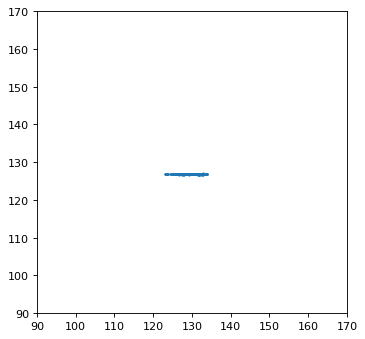

In [323]:
# make prediction
predicted = pred_model(lstm_regression, x_tr)

# evaluate the model
cal_error(y_tr_SBP, predicted)

### Model Building and fitting

In [6]:
def fit_lstm_regression(x_tr, y_tr, n_batch = 32, n_epoch = 100, epochs_to_wait_for_improve = 2):
    """
    Given the layer settings, build the LSTM model
    @Parameters:
    x_tr: array with shape(num_segments, num_pnts), training dataset.
    y_tr_SBP: array with shape(num_segments,), training label for SBP or DBP.
    n_batch: integer, batch size.
    n_epoch: integer, number of maximum epochs.
    @Returns:
    fitted_lstm: fitted LSTM model
    """
    dataDim = 1
    timeSteps = x_tr.shape[1]
    
    # design network
    lstm_regression = Sequential()
    lstm_regression.add(LSTM(
        32,
        input_shape = (timeSteps, dataDim),
        return_sequences = False))
    lstm_regression.add(Dropout(0.5))

#     lstm_regression.add(LSTM(
#         64,
#         return_sequences=False))
#     lstm_regression.add(Dropout(0.5))
    
    lstm_regression.add(Dense(
        64))
    lstm_regression.add(Activation("relu"))

    lstm_regression.add(Dense(
        32))
    lstm_regression.add(Activation("relu"))
    
    lstm_regression.add(Dense(1))
    lstm_regression.add(Activation("linear"))

    lstm_regression.compile(loss="mse", optimizer="adam")
    
    # for early stop
    filepath="weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    earlyStopping = EarlyStopping(monitor='val_loss', patience = epochs_to_wait_for_improve, verbose=0, mode='auto')
    callbacks_list = [checkpoint, earlyStopping]
    
    # fit the model
    history = lstm_regression.fit(
                x_tr,
                y_tr,
                batch_size = n_batch,
                epochs = n_epoch,
                verbose = 1,
                callbacks = callbacks_list,
                validation_split = 0.1)

    # print the model
    lstm_regression.summary()
    
    # load back the best parameters
    lstm_regression.load_weights(filepath)
        
    return lstm_regression

def pred_model(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
#     predicted = np.reshape(predicted, (predicted.shape[0],,))
    
    return predicted

def cal_error(true, pred):
    pred = pred[:,0]
    label = true
    R = np.corrcoef(pred, label)
    MAE = (np.absolute((pred - label))).mean()
    MAE_std = np.std((pred - label))
    RMSE = np.sqrt(((pred - label) ** 2).mean())
    print("R    = {}".format(R[0][1]))
    print("MAE  = {} +/- {}".format(MAE, MAE_std))
    print("RMSE = {}".format(RMSE))
    plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(label, pred, "o", markersize = 1)
    axes = plt.gca()
    axes.set_xlim([90,170])
    axes.set_ylim([90,170])
    plt.show()

### Train / Test Spliting

In [7]:
def tr_te_split(PPGseg, SBP, DBP, winLenInSec, tr_proportion = .8):
    """
    Split train, test dataset, according to requested training proportion.
    @Parameters:
    PPGseg: array with shape(num_segments, num_pnts)
    SBP: array with shape(num_segments,)
    DBP: array with shape(num_segments,)
    tr_proportion: float between 0.0 and 1.0, training proportion.
    @Returns:
    x_tr: array with shape(num_segments, num_pnts), training dataset
    y_tr_SBP: array with shape(num_segments,), training label for SBP
    y_tr_DBP: array with shape(num_segments,), training label for DBP
    x_te: array with shape(num_segments, num_pnts), testing dataset
    y_te_SBP: array with shape(num_segments,), testing label for SBP
    y_te_DBP: array with shape(num_segments,), testing label for DBP
    """
    row = round(tr_proportion * PPGseg.shape[0])
    x_tr = PPGseg[:int(row), :]
    x_te = PPGseg[(int(row) + winLenInSec * 2) :, :] # avoid overlap between training and testing dataset.
    # reshape data
    x_tr = x_tr.reshape(x_tr.shape[0], x_tr.shape[1], 1)
    x_te = x_te.reshape(x_te.shape[0], x_te.shape[1], 1)
    y_tr_SBP = SBP[:int(row)]
    y_tr_DBP = DBP[:int(row)]
    y_te_SBP = SBP[(int(row) + winLenInSec * 2) :]
    y_te_DBP = DBP[(int(row) + winLenInSec * 2) :]
    return x_tr, y_tr_SBP, y_tr_DBP, x_te, y_te_SBP, y_te_DBP

### Extract SBP and DBP from segmented ABP signal

In [8]:
## Extract SBP, DBP from true and estimated ABPseg
def extract_BP_from_ABPseg(ABPseg, srate, MinHight4SBP = 0.65, MaxHight4DBP = 0.9, MinDistance  = 0.4, show = False):
    """
    Extract SBP, DBP from true and estimated ABPseg.
    @Parameters:
    ABPseg: ABP signal, 1-D.
    srate: integer, sampling rate.
    MinHight4SBP: unit of second.
    MaxHight4DBP: unit of second.
    MinDistance: unit of second.
    @Return:
    SBP: a list of SBP values (associated with peaks on ABP signal)
    DBP: a list of DBP values (associated with valleys on ABP signal)
    """
    SBP, DBP = [], []

    # find the temporal location of peaks and valleys based on True data
    # Minimum height for SBP (peak of the signal)
    MinHight = MinHight4SBP * srate
    MaxHight = MaxHight4DBP * srate
    MinDist  = 0.4 * srate

    for i in range(ABPseg.shape[0]):
        cur = ABPseg[i,:]
        SBP_ind = detect_peaks(cur, mph = MinHight, mpd = MinDist, valley = False, show=show)
        DBP_ind = detect_peaks(cur, mph = -MaxHight, mpd = MinDist, valley = True, show=show)
        SBP.append(np.mean(cur[SBP_ind]))
        DBP.append(np.mean(cur[DBP_ind]))
        
    SBP, DBP = np.array(SBP), np.array(DBP)        

    return SBP, DBP

### Segmentation according to the peaks of PPG

In [9]:
def segmentation(data_part, rid=1, winLenInSec=2, srate=125, normFlag=True):
    """
    Perform segmentation for a given recording designated by PID and RID
    @Parameters:
    data_part: dictionary, loaded data part by function load_data_part
    rid: integer, RID, Recording ID, under associated PID.
    winLenInSec: integer, window length that used for the segementation. The unit is second.
    srate: integer, sampling rate of the loaded signal
    newSrate: integer, required sampling rate after down sampling. If no down sampling is required, newSrate = srate.
    normFlag: boolean, request normalization or not.
    @Return:
    PPGseg: array, shape(num_sample, num_winLenInPnt), segmented PPG signal
    ABPseg: array, shape(num_sample, num_winLenInPnt), segmented ABP signal
    """
    winLen = winLenInSec * srate

    # extract PPG and ABP signals from data_part dataset
    PPG, ABP = sig_extract(data_part, rid)

    # normalize PPG signal if requested
    if normFlag: PPG = normalize_entire(PPG)

    # identify the time index of peaks on PPG signal
    pk_idx = peak_identify(PPG, srate)

    # exclude pk_idx elements that is too early or too late according to the window length
    halfWinLen = winLen // 2
    pk_idx_usable = [x for x in pk_idx if x > halfWinLen and x < len(PPG) - halfWinLen]

    # initialize segmented data
    PPGseg, ABPseg = [], []
    for i in pk_idx_usable:
        PPGseg.append(PPG[i - halfWinLen : i + halfWinLen])
        ABPseg.append(ABP[i - halfWinLen : i + halfWinLen])
    PPGseg, ABPseg = np.array(PPGseg), np.array(ABPseg)
    
    return PPGseg, ABPseg

# Load Part with ID
def load_data_part(pid = 1):
    print ('> Loading data part_' + str(pid) + '...\n')
    data_part = scipy.io.loadmat('../database/KData/BloodPressureDataset/part_' + str(pid) + '.mat')
    print ('> Data part_' + str(pid) + ' loaded. \n')
    return data_part

# extract PPG and ABP signals from data_part dataset
def sig_extract(data_part, rid):
    """
    Extract PPG and ABP signals from a given data_part dataset.
    @Parameters:
    data_part: dictionary, loaded part dataset.
    rid: integer, RID, recording ID.
    @Returns:
    PPG: array with shape(num_pnt, ), entire PPG signal within recording.
    ABP: array with shape(num_pnt, ), entire ABP signal within recording.
    """
    data_raw = data_part['p'][0][rid]
    PPG = data_raw[0]
    ABP = data_raw[1]
    return PPG, ABP

# normalization for entire PPG signal within recording
def normalize_entire(PPG):
    """
    Normalizing entire PPG signal to between -1 and 1.
    @Parameters:
    PPG: array with shape(num_pnt, ), entire PPG signal within recording.
    @Returns:
    PPG_norm: array with shape(num_pnt, ), entire normalized PPG signal within recording.
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    PPG_norm = scaler.fit_transform(PPG.reshape(len(PPG), 1))
    return PPG_norm[:,0]

    
# identify time index for peaks on entire PPG signal within a recording
def peak_identify(PPG, srate = 125, minHight = .25, minDistInSec = .4):
    """
    Identify time index for peaks on entire PPG signal within a recording.
    @Parameters:
    PPG: array with shape(num_pnt, ), entire PPG signal within recording.
    minHight: float, minimum amplitude that could be considered as a peak.
    minDistInSec: float, minimum seconds after which another time point that could be considered as a index of peak.
    newSrate: sampling rate.
    @Returns:
    pk_idx: array with shape(num_peaks,)
    """
    pk_idx = detect_peaks(PPG, mph = minHight, mpd = minDistInSec * srate, valley = False, show=False)
    return pk_idx

# Checkpoint for function extract peak

> Loading data part_7...

> Data part_7 loaded. 



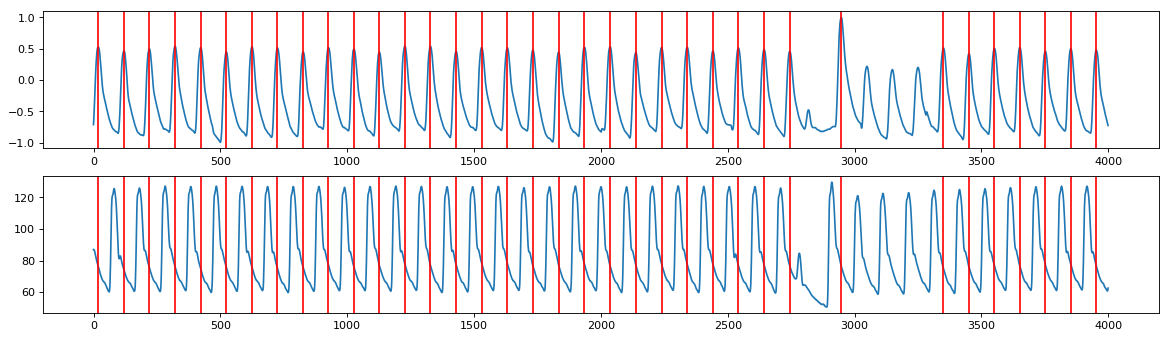

(144,)

In [128]:
pid = 7
data_part = load_data_part(pid)  

pid, rid, winLenInSec, srate, newSrate, normFlag = data_part, 1, 2, 125, 125, True

# extract PPG and ABP signals from data_part dataset
PPG, ABP = sig_extract(data_part, rid)

# normalize PPG signal if requested
if normFlag:
    PPG = normalize_entire(PPG)
#     ABP = normalize_entire(ABP)

length2plot = 4000
minHight = .25
MinDistance  = 0.4
pk_idx = peak_identify(PPG, srate = newSrate, minHight = minHight, minDistInSec = MinDistance)
pk_idx_test = [x for x in pk_idx if x < length2plot]
pk_idx_test

fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(211)
plt.plot(PPG[:length2plot])
for xc in pk_idx_test:
    plt.axvline(x=xc, color = 'r')
    
plt.subplot(212)
plt.plot(ABP[:length2plot])
for xc in pk_idx_test:
    plt.axvline(x=xc, color = 'r')
plt.show()
pk_idx.shape

### Checkpoint: test function extract_BP_from_ABPseg

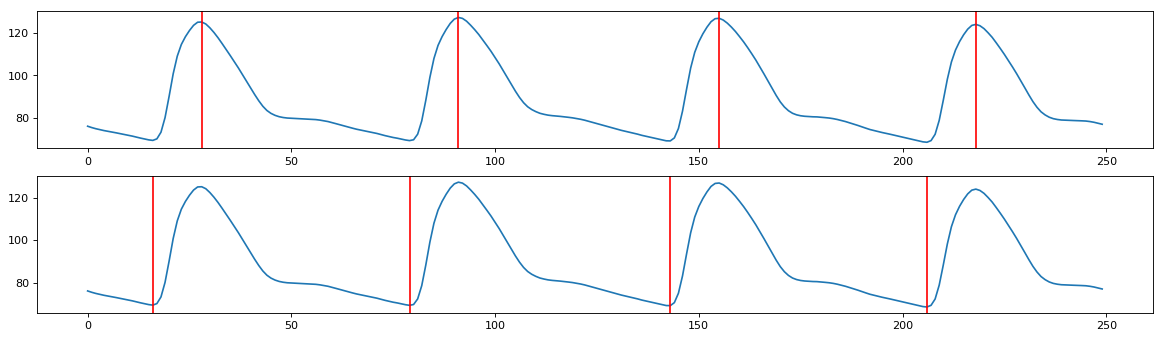

[125.23628335 127.38542394 126.99467111 124.11286896] [69.35862807 69.26093986 69.11440755 68.47943419]


In [198]:
minHight4SBP = .65
MaxHight4DBP = 0.9
MinDistance  = 0.4
show = False

SBP, DBP = [], []

# find the temporal location of peaks and valleys based on True data
# Minimum height for SBP (peak of the signal)
MinHight = MinHight4SBP * srate
MaxHight = MaxHight4DBP * srate
MinDist  = 0.4 * srate

for i in range(ABPseg.shape[0]):
    cur = ABPseg[i,:]
    SBP_ind = detect_peaks(cur, mph = MinHight, mpd = MinDist, valley = False, show=show)
    DBP_ind = detect_peaks(cur, mph = -MaxHight, mpd = MinDist, valley = True, show=show)
    SBP.append(np.mean(cur[SBP_ind]))
    DBP.append(np.mean(cur[DBP_ind]))

fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(211)
plt.plot(ABPseg[-1,:])
for xc in SBP_ind:
    plt.axvline(x=xc, color = 'r')
    
plt.subplot(212)
plt.plot(ABPseg[-1,:])
for xc in DBP_ind:
    plt.axvline(x=xc, color = 'r')
plt.show()
print(ABPseg[-1, SBP_ind], ABPseg[-1, DBP_ind])